<a href="https://colab.research.google.com/github/DuhmanM/CommitteeMeetingReports/blob/master/Northwestern_NMF_workshop_Part_1_NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **QBD2023 Workshop Part 1: NMF**

_"As simple as possible, but no simpler"_

Zach DeBrune, PhD and Tim Triche, Jr., PhD

# Introduction 

Today we want to share with you some tools that we find useful when trying to understand how millions of cells work together to develop into multicellular organisms. Sometimes, the same models also help us understand how that can fail. One tool that strikes a nice balance between power and understandable output is called NMF, or non-negative matrix factorization. We use it a lot, on millions of cells, but also in collections of rare disease samples and population-scale genetic databases. We feel that it helps us keep things "_as simple as possible, but no simpler_". Biology is complicated enough!

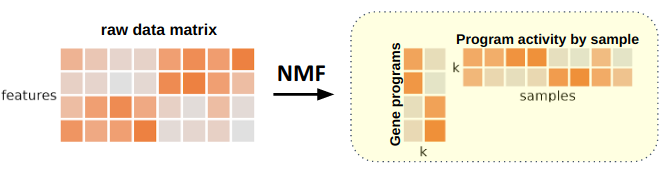

## Goals

**After this workshop, we want you to feel comfortable with:**

* dimension reduction, denoising, and annotation of gene programs with NMF (Part 1)
* accessing sources of well-annotated single cell data, such as CELLxGENE (segue to Part 2)
* how to fit new models and re-use existing models to explore new data (Part 2)


Screenshot from 2023-06-03 16-14-13.png


We are using Google Colab so you can share and hopefully build upon your work today. 

We'd love to see what you build with these tools in your own research!

#**Install various and sundry dependencies**



We need some packages for the code exercises in this workshop. 

Let's make sure we are running a reasonable operating system:

In [ ]:
system("cat /etc/issue", intern=TRUE)

[1] "Ubuntu 20.04.5 LTS \\n \\l" ""

OK, that's fine (albeit weird; current Jammy LTS is 20.04.6).

Let's install some necessary packages. `tidyverse` in particular needs some system libraries installed with `sudo`.


### Start early: system libraries (~20s)

**You are unlikely to regret running this code before you need it.**

The best time to have run this is 15 minutes ago. The second best time is now. 


In [ ]:
system("sudo apt update")
system("sudo apt install python3-apt python3-dbus python3-gi libharfbuzz-dev libfribidi-dev r-cran-tidyverse r-cran-devtools r-cran-bspm r-cran-remotes r-cran-biocmanager")
if (suppressPackageStartupMessages(require("tidyverse"))) message("Verified that `tidyverse` is installed.")

Verified that `tidyverse` is installed.



### Everything but `Seurat` & `singlet` (~1m)

We also try and install every binary package we can to avoid later delays from `Seurat` and `singlet` installation.

(It's a good idea to start this code running **a long time before you need it**! This step used to take 10-15 minutes.)

In [ ]:
system("sudo apt update")
system("sudo apt install r-cran-hexbin r-cran-abind r-cran-bh r-cran-viridis r-cran-bitops r-cran-catools r-cran-cowplot r-cran-crosstalk r-cran-deldir r-cran-dqrng r-cran-fitdistrplus r-cran-fnn r-cran-future r-cran-future.apply r-cran-ggrepel r-cran-ggridges r-cran-globals r-cran-goftest r-cran-gplots r-cran-gridextra r-cran-gtools r-cran-here r-cran-htmlwidgets r-cran-httpuv r-cran-ica r-cran-igraph r-cran-irlba r-cran-later r-cran-lazyeval r-cran-leiden r-cran-listenv r-cran-lmtest r-cran-matrixstats r-cran-miniui r-cran-parallelly r-cran-patchwork r-cran-pbapply r-cran-plotly r-cran-plyr r-cran-png r-cran-polyclip r-cran-progressr r-cran-promises r-cran-rann r-cran-rcpp r-cran-rcppannoy r-cran-rcpparmadillo r-cran-rcppeigen r-cran-rcppgsl r-cran-rcppprogress r-cran-rcpptoml r-cran-reshape2 r-cran-reticulate r-cran-rocr r-cran-rtsne r-cran-scattermore r-cran-sctransform r-cran-seuratobject r-cran-shiny r-cran-shinyace r-cran-shinyjs r-cran-shinywidgets r-cran-sitmo r-cran-sourcetools r-cran-sp r-cran-spatstat.data r-cran-spatstat.explore r-cran-spatstat.geom r-cran-spatstat.random r-cran-spatstat.sparse r-cran-spatstat.utils r-cran-tensor r-cran-uwot r-cran-xtable r-cran-zoo")
system("sudo apt install r-bioc-limma r-bioc-fgsea")
if (suppressPackageStartupMessages(require("SeuratObject"))) message("Verified that `SeuratObject` is installed.")

Verified that `SeuratObject` is installed.



### Installing `Seurat` (1-2m)

`Seurat` can take a while to install, since it depends on every package ever written and then a couple others.

We chopped this down quite a bit above, but it can still take a while. As always, **it's never too late to be early.**

In [ ]:
suppressWarnings(suppressMessages(BiocManager::install("Seurat", update=FALSE, quiet=TRUE, ask=FALSE))) # hush!
if (suppressPackageStartupMessages(require("Seurat"))) message("Verified that `Seurat` is installed and loaded.")

Verified that `Seurat` is installed and loaded.



### Updating `RcppML` (~1m)

The version of `RcppML` on GitHub is more recent than that on CRAN, so we'll use it for NMF-related calculations and manipulations.

(Incidentally, have I mentioned that you want to run these code chunks **before you need them**? Just checking.)

In [ ]:
suppressMessages(BiocManager::install("zdebruine/RcppML", quiet=TRUE))
if (require("RcppML", quiet=TRUE)) message("Finished updating RcppML from GitHub.")

RcppML v0.5.5 using 'options(RcppML.threads = 0)' (all available threads), 'options(RcppML.verbose = FALSE)'

Finished updating RcppML from GitHub.



### Installing Bioconductor stuff (1-10m)

`scuttle` is a handy package for single-cell preprocessing that we sometimes use in `singlet`.

Unfortunately it isn't available as a binary so we have to compile it. That takes a minute or two (depending on the instance).

In [ ]:
suppressMessages(suppressWarnings(BiocManager::install("scuttle", update=FALSE, quiet=TRUE, ask=FALSE)))
if (suppressPackageStartupMessages(require("scuttle", quiet=TRUE))) message("Finished updating prerequisites.")


Finished updating prerequisites.



### Installing `singlet` (2-4m)

Let's install `singlet` from GitHub, since that's currently where it lives.

You might also consider running this code a few minutes ahead of time.

In [ ]:
suppressWarnings(suppressMessages(BiocManager::install("zdebruine/singlet", force=TRUE, update=TRUE, quiet=TRUE)))
if (require("singlet", quiet=TRUE)) message("Finished installing singlet from GitHub.")

Finished installing singlet from GitHub.



### One last thing: run this early

Hey, did I mention that you'll be happier if you run all the above code chunks ahead of time? Just wanted to make sure we don't forget!

# A guided tour of NMF with PBMC3K

Just in case you haven't run the installation steps above, please for the love of all that's holy, do so. The best time was 15 minutes ago. The second best time is right now! Moving along...

[`Seurat`](https://satijalab.org/seurat/) ships with some excellent tutorials. Let's retrace the steps in one, using data from about 3000 peripheral blood mononuclear cells. 

Rather than just using the more common principal components analysis, we will also use non-negative matrix factorization (NMF) to denoise and compress the data from the cells. Some reasons why you might want to do such a thing can be found in [the FASTNMF paper](https://www.biorxiv.org/content/10.1101/2021.09.01.458620v1.full), but the short version is that we think it produces results which are usually easier to interpret than PCA. Caveat lector: use the best tool for _your_ experiment and design, whether or not that's NMF.

Output from the `singlet` example can also be found [here](https://zdebruine.github.io/singlet/articles/Guided_Clustering_with_NMF.html) if you want to check your work or just skip ahead a little bit.

### Preliminaries

In [ ]:
library(singlet)

Let's load the PBMC3K data for the tour.

In [ ]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(Matrix))
data <- get_pbmc3k_data()
data

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

OK, that's 13714 genes measured across 2700 cells (close enough to 3K).

### Normalization


It's wise to log-normalize (or more accurately, `log(1 + (count / total_counts))` normalize) RNA-sequencing data before applying anything that assumes linearity of residuals, so that's the first thing we do.

In [ ]:
(data <- NormalizeData(data))

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

We can look at the result grapically:

Loading required package: viridisLite



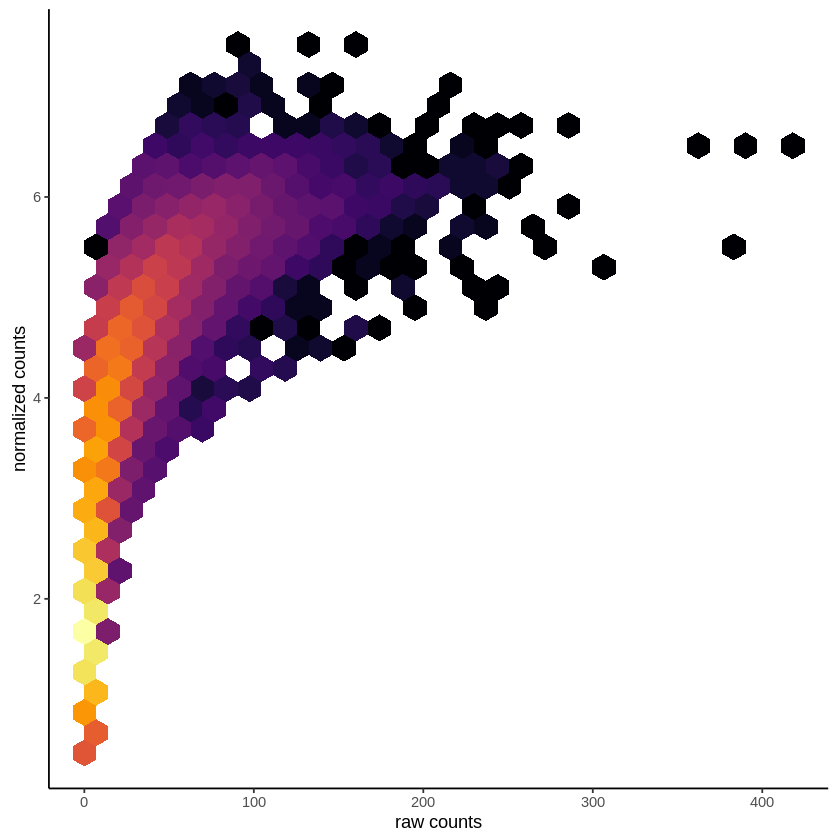

In [ ]:
library(ggplot2)
library(viridis)
ggplot(data.frame("x" = data@assays$RNA@counts@x, 
                  "y" = data@assays$RNA@data@x), 
       aes(x, y)) + 
  geom_hex() + 
  scale_fill_viridis(option = "B", trans = "log10") + 
  theme_classic() + 
  theme(aspect.ratio = 1, legend.position = "none") +
  labs(x = "raw counts", y = "normalized counts")

The critical thing to remember is that, when you use any sort of a linear decomposition (i.e. "weighted combinations of things"), it implicitly assumes that the mean and variance of your measurements are not correlated. Log-transforming the counts ensures that's roughly true. 

You can perform a lot of hijinks that take a lot of time, but [it is surprisingly difficult to do much better than log-normalization](https://www.nature.com/articles/s41592-023-01814-1) unless you're willing to add [specifically designed control sequences](https://www.nature.com/articles/s41592-022-01446-x), at which point you just change the denominator.


### Quality control 



In a typical single-cell experiment, the number of reads per cell can vary significantly. Below, we plot the number of identified features in each cell against the number of total mapped reads in that cell.

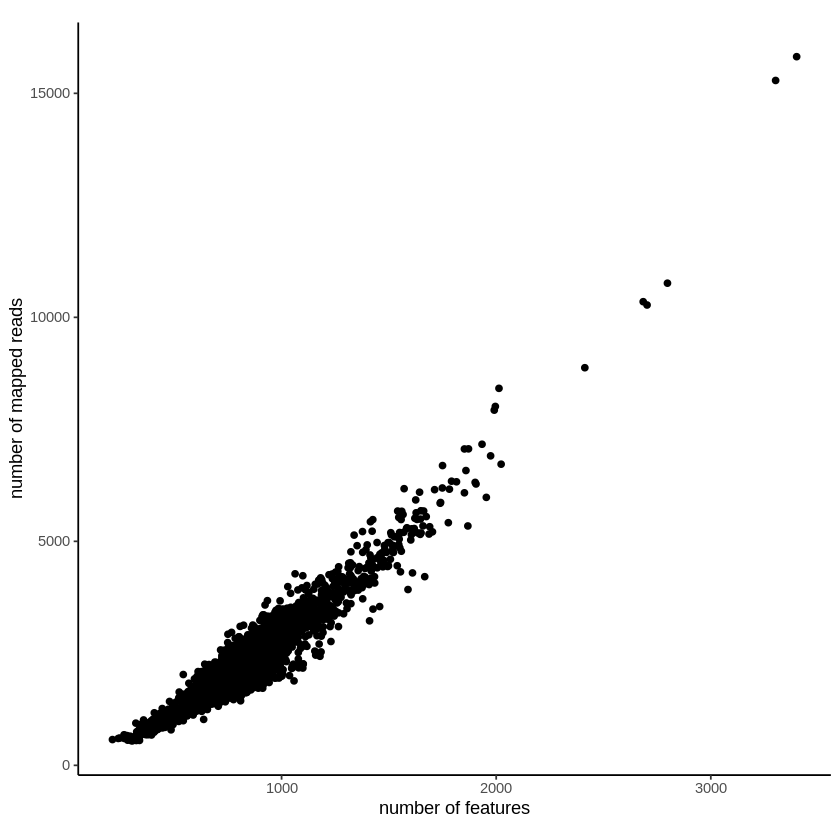

In [ ]:
ggplot(data.frame("x" = colSums(data@assays$RNA@counts != 0), 
                  "y" = colSums(data@assays$RNA@counts)), aes(x, y)) +
  geom_point() +
  theme_classic() +
  theme(aspect.ratio = 1) +
  labs(x = "number of features", y = "number of mapped reads")

Having too many features may indicate a poor quality cell, or more than one cell in the droplet. Having too few mapped reads can indicate an empty droplet. We will subset our data to the cells with unique reads under 2,500 and more than 200 unique features:


In [ ]:
data <- data[, which(colSums(data@assays$RNA@counts != 0) > 200 & colSums(data@assays$RNA@counts) < 2500)]

### Principal components analysis



Let's run PCA (so that we can compare against The Standard).

Seurat advises selecting highly variable genes (HVGs, usually 2000 or 3000), centering and scaling the data, and then running PCA. These are all available in Seurat and are discussed in more detail in the [Seurat Guided Clustering Tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html).

By default, Seurat tells you which genes are heavily weighted both positively and negatively for each component. You might say to yourself, "why do I want negative activation as a motif?" We certainly did. More on that later.


In [ ]:
data <- FindVariableFeatures(data, nfeatures = 1999)
data <- ScaleData(data)
data <- RunPCA(data, features = VariableFeatures(object = data), npcs = 50) 

Centering and scaling data matrix

PC_ 1 
Positive:  MALAT1, RPS3A, IL32, RPS3, RPS6, RPL13A, LTB, B2M, TPT1, RPS5 
	   CD7, AES, RPL13, CTSW, IL7R, GLTSCR2, RPL19, CD2, TMEM66, GZMM 
	   CD247, CST7, STK17A, GZMA, NKG7, HINT1, CCL5, ACAP1, TRAF3IP3, GIMAP5 
Negative:  S100A9, S100A8, CST3, FCN1, LGALS2, LYZ, FTL, LST1, AIF1, FTH1 
	   TYROBP, CFD, TYMP, LGALS1, FCER1G, CD14, GPX1, MS4A6A, SAT1, CTSS 
	   GRN, CDA, IFI30, COTL1, GSTP1, S100A11, PSAP, SPI1, LGALS3, IFITM3 
PC_ 2 
Positive:  CD79A, HLA-DQA1, HLA-DQB1, TCL1A, HLA-DRA, RPL13, CD79B, RPL13A, LTB, LINC00926 
	   VPREB3, HLA-DRB1, RPL8, CD74, HLA-DPB1, HLA-DPA1, RPS5, HLA-DMA, CD37, HLA-DMB 
	   RPL19, RPS6, HVCN1, FCRLA, EAF2, IRF8, LY86, BLNK, KIAA0125, P2RX5 
Negative:  NKG7, GZMB, PRF1, CST7, GZMA, FGFBP2, CTSW, GNLY, FCGR3A, SPON2 
	   B2M, CCL4, SRGN, CCL5, GZMH, GZMM, CD247, S100A4, XCL2, CLIC3 
	   IGFBP7, AKR1C3, APMAP, ACTB, TPST2, HOPX, ID2, ANXA1, GPR56, TMSB4X 
PC_ 3 
Positive:  RPS6, RPL13, RPL19, RPS3, S100A4, 

Here we calculate the first 50 principal components.

Why 50 PCs? Well, why NOT 50 PCs? It's arbitrary. We'll provide what we think is a better answer in a moment. For now, to determine how many of these 50 components we should keep, we can plot the diagonal weights (additional explained standard deviation) of each component:


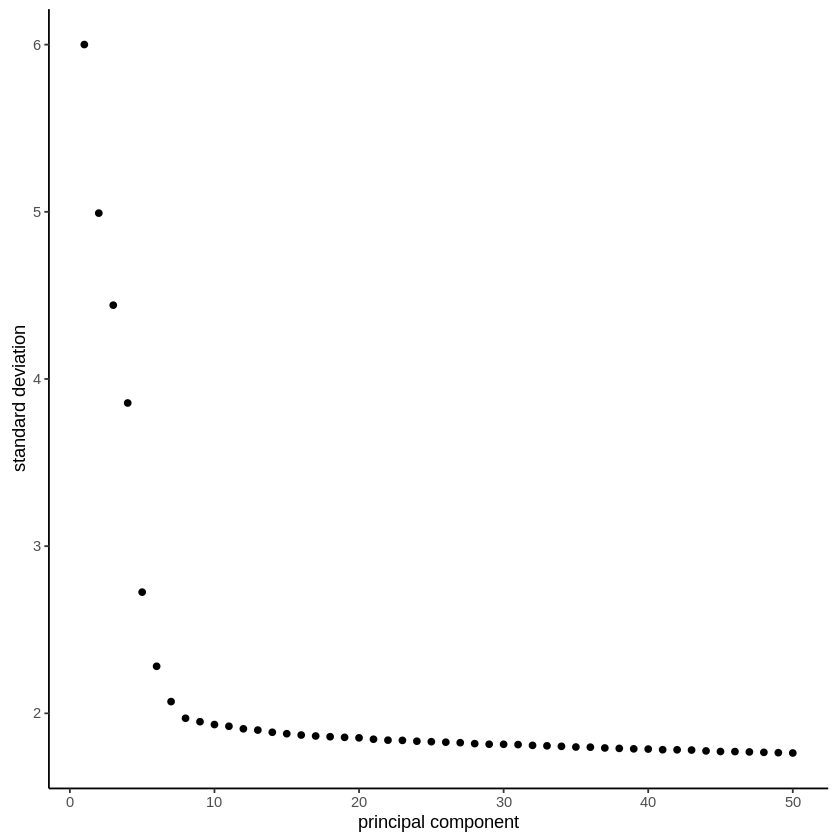

In [ ]:
ggplot(data.frame("x" = 1:50, 
                  "y" = data@reductions$pca@stdev), 
       aes(x, y)) +
    geom_point() + 
    theme_classic() + 
    theme(aspect.ratio = 1) +
    labs(x = "principal component", y = "standard deviation")

Estimate the inflection point (the **"elbow"**) and use that many principal components downstream. Here, the inflection point is around 10, so we keep PCs 1-10. (If we use too many components, we admit noise to our analysis. If we keep too few, we lose relevant biological signal.)

Note that there are several ways to perform cross-validation of PCA (none of them are particularly attractive), but they all involve some sort of estimation of the inflection point and can be computationally intensive. This fast method tends to give reasonable results.



### Visualizing the PCA Model



A popular way of visualizing PCA models is to plot the first two components against one another. This allows us to see how the samples separate along the most significant two axes of variation. To make things interesting, we will color by cell type as annotated by Seurat:


In [ ]:
ggplot() + geom_point(aes(x = data@reductions$pca@cell.embeddings[,1], 
           y = data@reductions$pca@cell.embeddings[,2], 
           color = data@meta.data$cell_type)) +
  theme_classic() + 
  theme(aspect.ratio = 1) + 
  labs(x = "PC1", y = "PC2", color = "cell type")

### UMAP, I map, we all map



The cell types separate well, however this visualization only uses information from the first two components. To use additional axes of variation, we can try smashing the data nonlinearly into a UMAP plot. (Reasonable people can debate the wisdom of reducing dimensionality twice.) UMAP is short for Uniform Manifold and Approximation and Projection.


In [ ]:
suppressPackageStartupMessages(require("uwot"))

umap_coordinates <- uwot::umap(data@reductions$pca@cell.embeddings[,1:10], metric = "cosine", min_dist = 0.3)

plot_umap <- function(umap_coordinates, color_by){
  ggplot() + geom_point(aes(x = umap_coordinates[,1], 
             y = umap_coordinates[,2], 
             color = color_by), 
             size = 0.7) +
    theme_classic() + 
    theme(aspect.ratio = 1) + 
    labs(x = "UMAP 1", y = "UMAP 2", color = "cell type") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text = element_blank(), 
          axis.title = element_text(hjust = 0, vjust = 0), 
          axis.ticks = element_blank())
}

plot_umap(umap_coordinates, color_by = data@meta.data$cell_type)

Most of the cell types separate much better.

What happens when we use fewer components?


In [ ]:
umap_4 <- uwot::umap(data@reductions$pca@cell.embeddings[,1:4], metric = "cosine", min_dist = 0.3)
plot_umap(umap_4, color_by = data@meta.data$cell_type)


What happens when we use more components?


In [ ]:
umap_50 <- uwot::umap(data@reductions$pca@cell.embeddings[,1:50], metric = "cosine", min_dist = 0.3)
plot_umap(umap_50, color_by = data@meta.data$cell_type)

What do these under- and over-shoot exercises look like in context?

In [ ]:
library(cowplot)
cowplot::plot_grid(
  plot_umap(umap_4, data@meta.data$cell_type) + ggtitle("too few components (4)") + theme(legend.position = "none"),
  plot_umap(umap_50, data@meta.data$cell_type) + ggtitle("too many components (50)") + theme(legend.position = "none"),
  get_legend(plot_umap(umap_4, data@meta.data$cell_type)),
  ncol = 3, rel_widths = c(1, 1, 0.5))

Note that too few components does not fully separate cell types, but too many components does not add meaningful information.

If you [skip ahead a tiny bit](#scrollTo=3fKYSjXwMTwv), you'll see that we just brute-force this issue and ask "how well can we recover the original data from the reduced dimensional model?" Whatever number of factors gives us the minimum reconstruction error (the dip in the cross-validation fit), that's the one we use.  For big models we randomly permute a few times and take the quorum.

### Comparison with NMF

Run NMF (this takes about 3 minutes in Google Colab):

In [ ]:
set.seed(2023)
data <- singlet::RunNMF(data, reps = 1, trace.test.mse = 1)
data

running with sparse optimization
k = 2 , rep = 1 
   test_error = 1.4343e-01 
   not overfit
   best rank in replicate = 2 

k = 3 , rep = 1 
   test_error = 1.4109e-01 
   not overfit
   best rank in replicate = 3 

k = 6 , rep = 1 
   test_error = 1.3874e-01 
   not overfit
   best rank in replicate = 6 

k = 11 , rep = 1 
   test_error = 1.3800e-01 
   not overfit
   best rank in replicate = 11 

k = 21 , rep = 1 
   test_error = 1.3848e-01 
   not overfit
   best rank in replicate = 11 

k = 16 , rep = 1 
   test_error = 1.3815e-01 
   not overfit
   best rank in replicate = 11 

k = 9 , rep = 1 
   test_error = 1.3808e-01 
   not overfit
   best rank in replicate = 11 

k = 13 , rep = 1 
   test_error = 1.3803e-01 
   not overfit
   best rank in replicate = 11 

k = 10 , rep = 1 
   test_error = 1.3798e-01 
   not overfit
   best rank in replicate = 10 


Unmasking test set
Fitting final model at k = 10 


An object of class Seurat 
13714 features across 1758 samples within 1 assay 
Active assay: RNA (13714 features, 1999 variable features)
 2 dimensional reductions calculated: pca, nmf

Plot the cross-validation results:

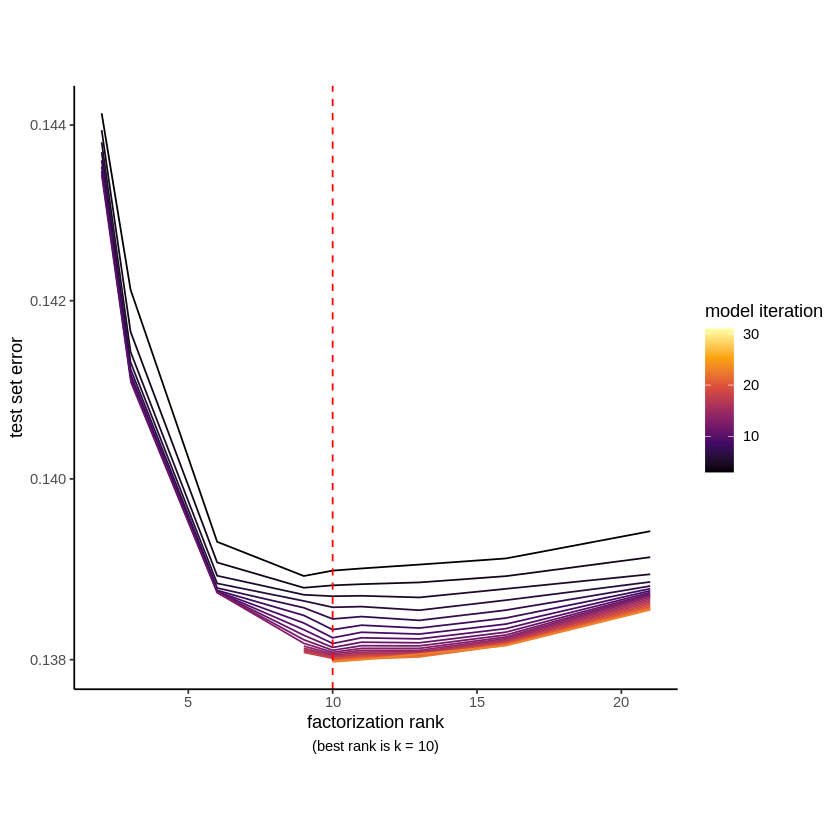

In [ ]:
plot(subset(data@reductions$nmf@misc$cv_data, iter > 2))

Plot the loadings of each factor:


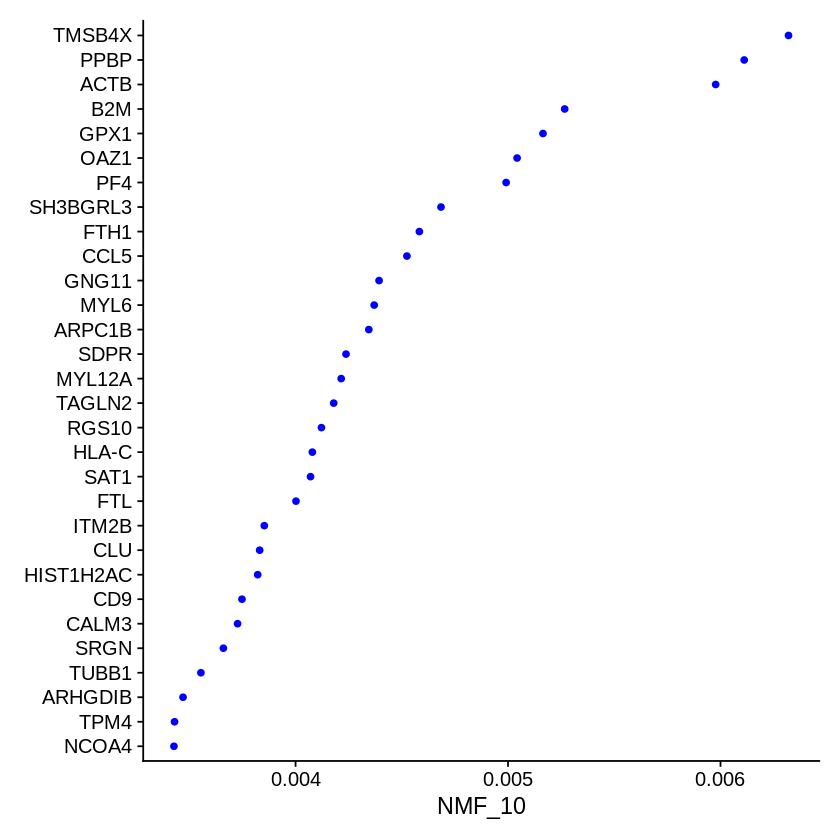

In [ ]:
VizDimLoadings(data, dims = ncol(data@reductions$nmf@feature.loadings), reduction = "nmf")

Add a UMAP plot:


In [ ]:
data <- RunUMAP(data, reduction = "nmf", reduction.name = "umap_nmf", dims = 1:ncol(data@reductions$nmf), verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [ ]:
feature_plot <- function(umap_coordinates, color_by){
  ggplot() + geom_point(aes(x = umap_coordinates[,1], 
             y = umap_coordinates[,2], 
             color = color_by), 
             size = 0.7) +
    theme_classic() + 
    theme(aspect.ratio = 1) + 
    labs(x = "UMAP 1", y = "UMAP 2", color = "weight") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text = element_blank(), 
          axis.title = element_text(hjust = 0, vjust = 0), 
          axis.ticks = element_blank()) +
    scale_color_gradient2(mid = "gray")
}

cowplot::plot_grid(plotlist = lapply(1:4, function(nmf_factor){
  feature_plot(data@reductions$umap_nmf@cell.embeddings, data@reductions$nmf@cell.embeddings[, nmf_factor]) +
    ggtitle(paste0("NMF factor ", nmf_factor)) +
    theme(legend.position = "none")
}), ncol = 2)


Compare to PCA:


In [ ]:
cowplot::plot_grid(plotlist = lapply(1:4, function(pc){
  feature_plot(data@reductions$umap@cell.embeddings, data@reductions$pca@cell.embeddings[, pc]) +
    ggtitle(paste0("Principal component ", pc)) +
    theme(legend.position = "none")
}), ncol = 2)

To a first approximation, NMF tends to recover cell-type-specific (or, with appropriate penalties, development-specific) gene programs, whereas PCA will always separate out the largest orthogonal ("at-right-angles-to-each-other") sources of variance regardless of their origin. The latter is obvious to anyone who has looked at the math; the former is a bit more subtle, but it boils down to the objective function in NMF favoring "part-wise" decomposition, and (further) the effect of the scaling diagonal in fastNMF.


### Visualizing factors



Let's see what NMF factors are associated with what cell types:

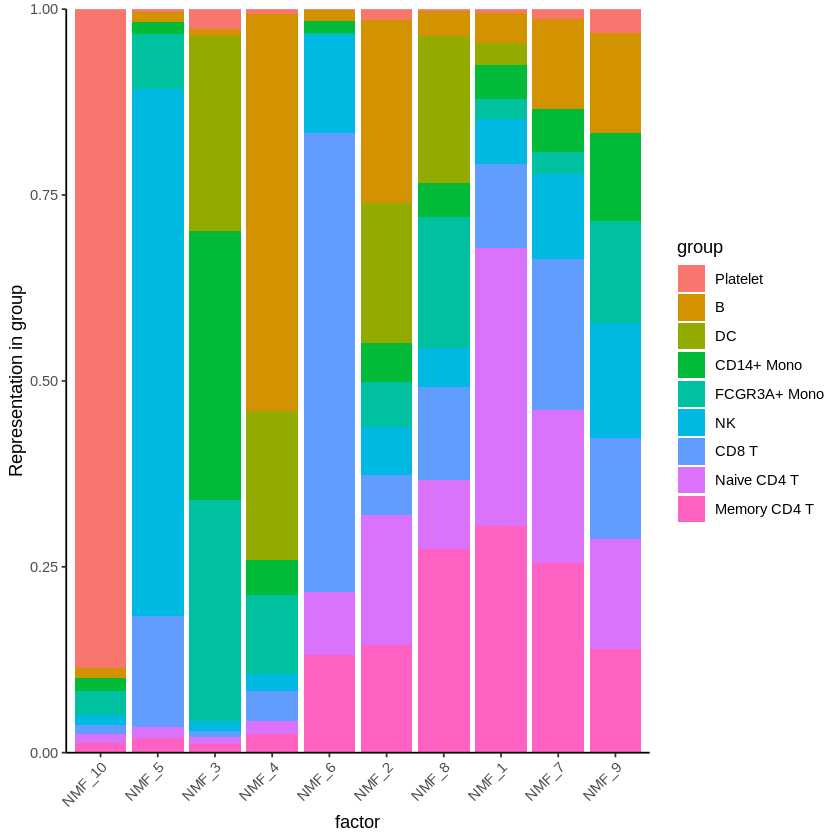

In [ ]:
MetadataPlot(data, "cell_type", reduction = "nmf")

We can also perform graph-based clustering on the NMF embedding to see how our result compares to that of the Seurat authors (Satija lab):


In [ ]:
data <- FindNeighbors(data, dims = 1:ncol(data@reductions$nmf), reduction = "nmf")
data <- FindClusters(data, resolution = 0.5, verbose = FALSE)
names(data@meta.data)

Computing nearest neighbor graph

Computing SNN



[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "cell_type"      
[5] "RNA_snn_res.0.5" "seurat_clusters"

In [ ]:
df <- data.frame(
  "nmf_clusters" = data@meta.data$seurat_clusters,
  "pca_clusters" = data@meta.data$cell_type
)
head(df)

nmf_clusters pca_clusters
1 1            Memory CD4 T
2 5            NK          
3 4            Memory CD4 T
4 1            CD8 T       
5 1            CD8 T       
6 1            Naive CD4 T

In [ ]:
df <- df[!is.na(df$pca_clusters), ]
(tbl <- with(df, table(pca_clusters, nmf_clusters)))

              nmf_clusters
pca_clusters     0   1   2   3   4   5   6
  Naive CD4 T  362  53   0   0  89   0   0
  Memory CD4 T  26  24   0   0 174   0   0
  CD14+ Mono     0   0 260   0   0   0   0
  B              0   1   0 289   0   0   0
  CD8 T          0 232   0   0   8   5   1
  FCGR3A+ Mono   0   0  26   0   0   0   0
  NK             0   5   0   0   0 137   0
  DC             0   0   1   0   0   0   0
  Platelet       0   0   1   0   0   0  11

In [ ]:
df2 <- as.data.frame(tbl)
head(df2)

pca_clusters nmf_clusters Freq
1 Naive CD4 T  0            362 
2 Memory CD4 T 0             26 
3 CD14+ Mono   0              0 
4 B            0              0 
5 CD8 T        0              0 
6 FCGR3A+ Mono 0              0

In [ ]:
(tbl2 <- sweep(tbl, 1, rowSums(tbl), `/`))
df3 <- as.data.frame(tbl2)
head(df3)

              nmf_clusters
pca_clusters             0           1           2           3           4
  Naive CD4 T  0.718253968 0.105158730 0.000000000 0.000000000 0.176587302
  Memory CD4 T 0.116071429 0.107142857 0.000000000 0.000000000 0.776785714
  CD14+ Mono   0.000000000 0.000000000 1.000000000 0.000000000 0.000000000
  B            0.000000000 0.003448276 0.000000000 0.996551724 0.000000000
  CD8 T        0.000000000 0.943089431 0.000000000 0.000000000 0.032520325
  FCGR3A+ Mono 0.000000000 0.000000000 1.000000000 0.000000000 0.000000000
  NK           0.000000000 0.035211268 0.000000000 0.000000000 0.000000000
  DC           0.000000000 0.000000000 1.000000000 0.000000000 0.000000000
  Platelet     0.000000000 0.000000000 0.083333333 0.000000000 0.000000000
              nmf_clusters
pca_clusters             5           6
  Naive CD4 T  0.000000000 0.000000000
  Memory CD4 T 0.000000000 0.000000000
  CD14+ Mono   0.000000000 0.000000000
  B            0.000000000 0.000000000
 

pca_clusters nmf_clusters Freq     
1 Naive CD4 T  0            0.7182540
2 Memory CD4 T 0            0.1160714
3 CD14+ Mono   0            0.0000000
4 B            0            0.0000000
5 CD8 T        0            0.0000000
6 FCGR3A+ Mono 0            0.0000000

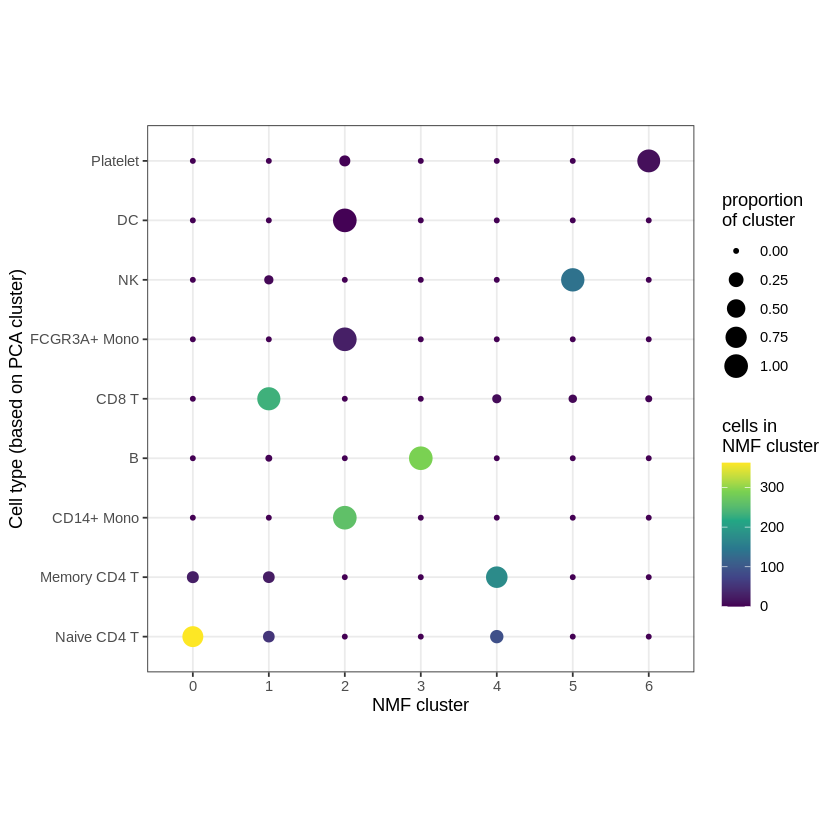

In [ ]:
names(df2) <- sub("Freq", "n", names(df2))
df2$freq <- df3$Freq

ggplot(df2, aes(nmf_clusters, pca_clusters, size = freq, color = n)) + 
  geom_point() + 
  theme_bw() + 
  labs(x = "NMF cluster", 
       y = "Cell type (based on PCA cluster)", 
       size = "proportion\nof cluster", 
       color = "cells in\nNMF cluster") + 
  scale_color_viridis_c(option = "D") + 
  theme(aspect.ratio = 1)

Compared to the PCA clustering (see the Seurat vignette), the NMF clustering more completely resolves NK cells and better resolves CD8 T-cells from Memory CD4 T-cells, but does not identify a small cluster of dendritic cells (DCs) annotated in the Seurat vignette.

These results show how PCA and NMF can be used to achieve very similar results for cell clustering. Based on GSEA enrichment and factor weights, though, we find that NMF models are more interpretable and usually capture more biology.

# CELLxGENE Discover (segue to Part 2)

While using NMF on a decade-old single-cell RNAseq dataset is expedient, that's probably not what you came here to learn about. Fortunately, the explosion of single-cell transcriptomic, multi-omic, and spatial data has provided an awful lot of opportunities for data reuse and data integration. One of the best maintained, best annotated, and easiest places to start is the database housing the Human Cell Atlas, which has been renamed [CELLxGENE](https://cellxgene.cziscience.com/) (since it now has mouse and fish atlases, too). As microscopy and spatial transcriptomics starts to merge with single-cell suspension-based transcriptome and multiome work, you can expect to see more changes in the way that CELLxGENE organizes these results. For example, we are working with the fine folks at CZI to add a large (more or less complete) NMF model of gene programs operating in development directly into the CELLxGENE database. The hope is that by providing "gene program" activity alongside single-cell activity, both known and unknown genes and expression programs can be more rapidly studied and, eventually, their role in normal and abnormal development understood. Even if you don't want to write a single line of code or search a single database, though, you can use data from [all 50 million cells in CELLxGENE](https://cellxgene.cziscience.com/gene-expression) directly from the web.  (_Activity: tour CELLxGENE expression web with MBD2/MBD3 in brain cells_) 


Screenshot from 2023-06-03 16-52-16.png


"But wait!" you say. "That's just a silly website! I want _RAW DATA_!!1"

Worry not, gentle reader. We will get our hands very dirty in Part 2!